# Explaining Models with SHAP

Kris Barbier

In [6]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [7]:
#Model evaluation function
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [8]:
#Import model with joblib
import joblib
loaded = joblib.load('random_forest_l01.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForest'])

In [9]:
#Load in each variable
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']

In [10]:
#Evaluate loaded model
evaluate_regression(loaded_model, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 424.61
Test Data:	R^2= 0.56	RMSE= 1104.76


In [12]:
#Import SHAP
import shap
shap.initjs()

In [13]:
#Check length of X_train_df
len(X_train_df)

6392

In [15]:
#Create X_shap variable
X_shap = shap.sample(X_train_df, nsamples = 400, random_state = SEED)
X_shap

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
3888,15.850,0.110653,36.9506,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2497,15.100,0.087407,221.8456,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7723,17.500,0.015592,184.8266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8117,10.800,0.049820,243.2144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7475,15.000,0.044999,140.4838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,12.850,0.033288,198.4768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3035,8.895,0.088682,121.9730,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6832,10.395,0.030282,116.3176,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8455,18.000,0.073607,156.6972,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
#Get corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

3888     759.0120
2497     663.1368
7723    2766.3990
8117    1225.0720
7475    1685.8056
          ...    
292     1379.5376
3035    2956.1520
6832    1259.6936
8455    4206.5244
7795     605.8780
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [17]:
#Instantiate explainer
explainer = shap.Explainer(loaded_model)
explainer

In [19]:
#Get shap values
shap_values = explainer(X_shap, y_shap)
shap_values.shape


(400, 41)

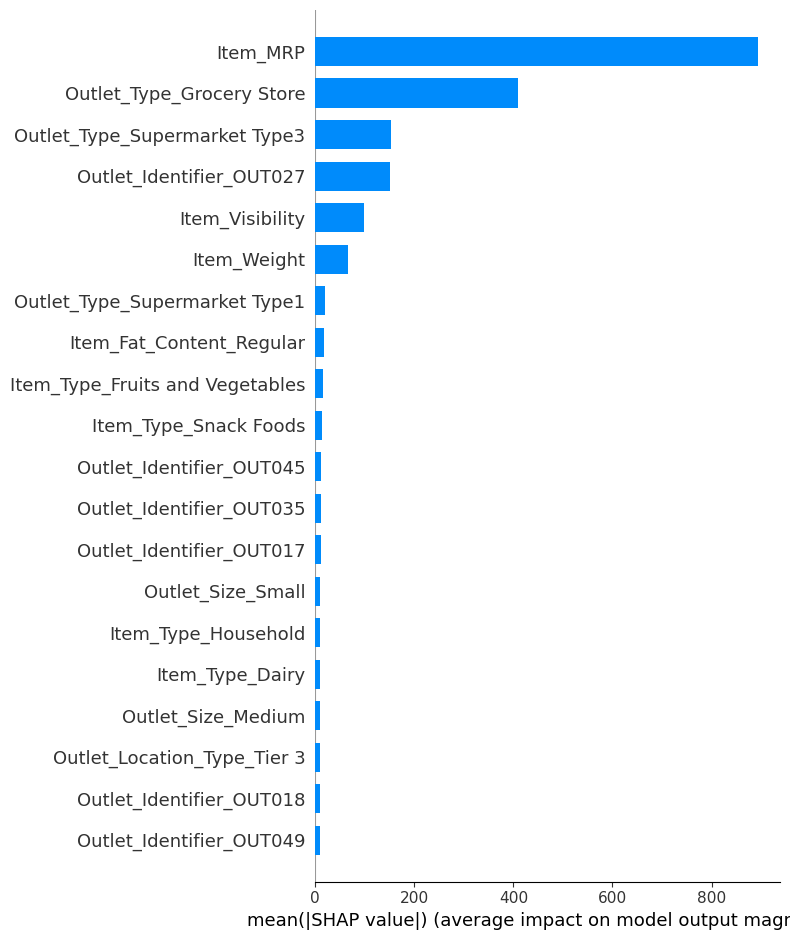

In [20]:
#Create shap bar plot
shap.summary_plot(shap_values, features = X_shap, plot_type = 'bar')

<img src="Feature Importances.png" width=60%>

- In both the SHAP plot and the original feature importancs, we see some commonalities. In both plots, Item_MRP is the top feature used, followed by Outlet_Type_Grocery Store. The SHAP plot has Item_Visibility and Item_Weight as the next features, whereas in the original feature importances plot, these two are a little further down. The other two features that round out the top 6 are Outlet_Type_Supermarket 3, and Outlet_Identifier_OUT027. Both plots show that these are the top 6 features used.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


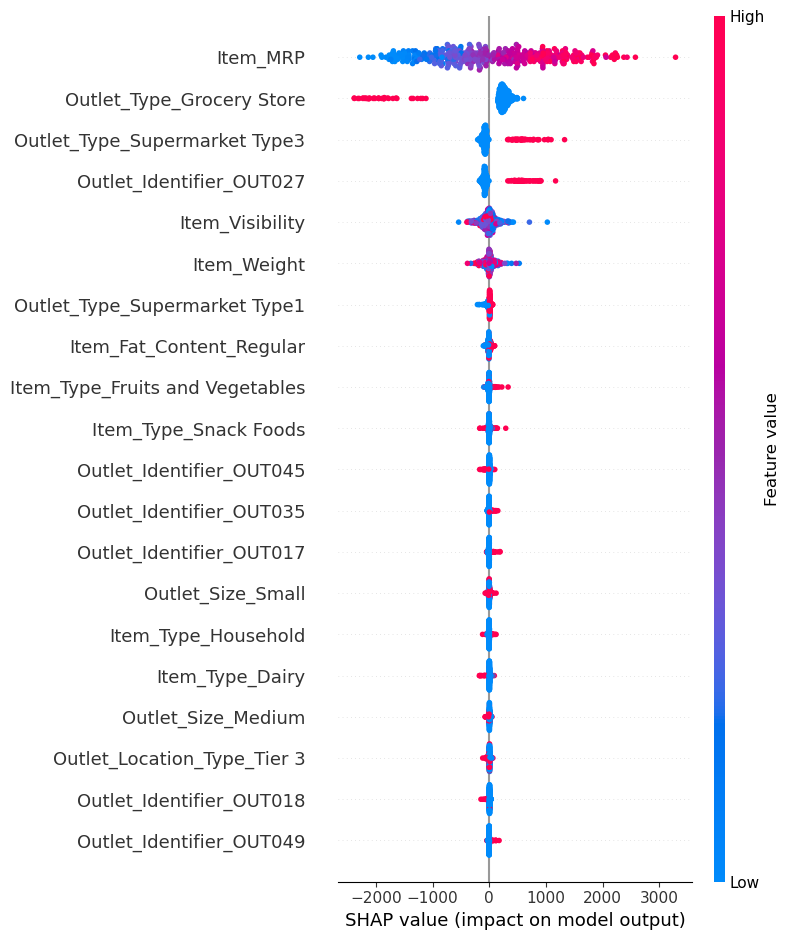

In [21]:
#Create summary dot plot
shap.summary_plot(shap_values, features = X_shap)

- The top three features are: Item_MRP, Outlet_Type_Grocery Store, and Outlet_Type_Supermarket 3.

    - Item_MRP: The SHAP plot shows a higher concentration of red values toward the right side of the plot. This means that higher values in this feature will increase and item's sales.
    - Outlet_Type_Grocery Store: For this feature, the red values are most concentrated to the left of 0. This means that if an outlet is identified as a grocery store, then an item will sell for less.
    - Outlet_Type_Supermarket 3: This feature has higher concentrations of red values greater than 0. This means that outlets that are this type will result in greater sales.

## Save SHAP Plots

In [22]:
import os
os.makedirs("images/", exist_ok=True)

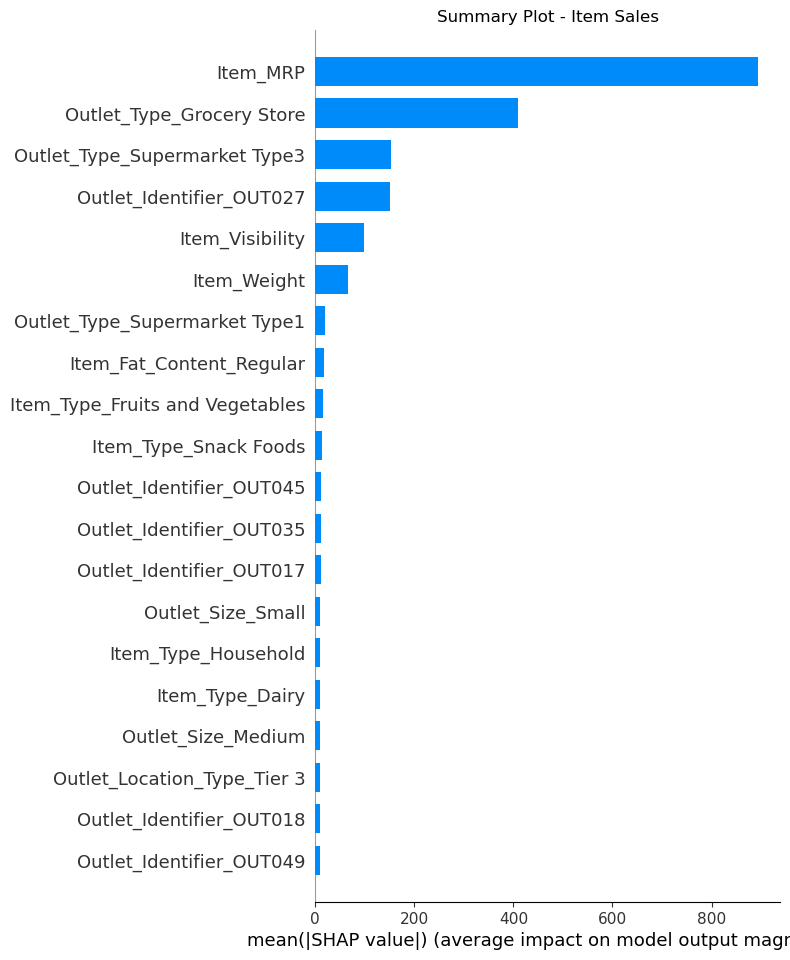

In [23]:
#Save bar plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, plot_type = 'bar', show=False)
ax.set_title('Summary Plot - Item Sales');
fig.savefig('images/summary_plot_1.png')


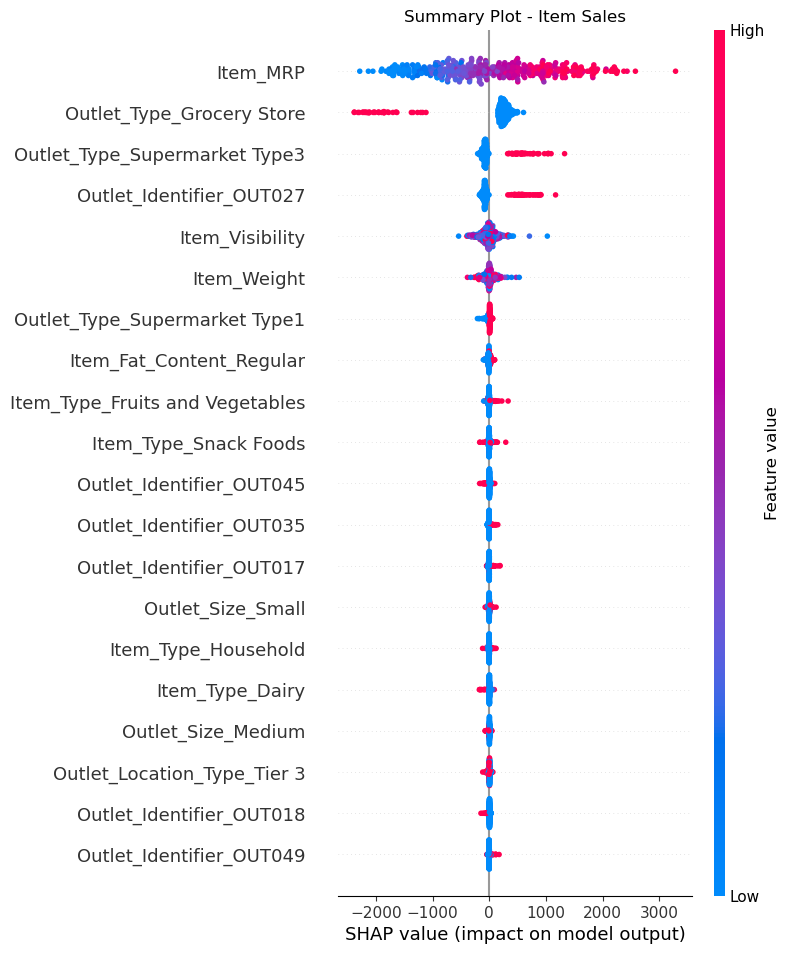

In [24]:
#Save dot plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_shap, show=False)
ax.set_title('Summary Plot - Item Sales');
fig.savefig('images/summary_plot_2.png')